In [97]:
%reload_ext autoreload
%autoreload 2
from paperexps import experiment_map
# from experiments import experiment_map
from helper import *
from plot_helper import *
import itertools, subprocess
import os, re
os.chdir("/home/wangzhao/experiments/DBx1000")

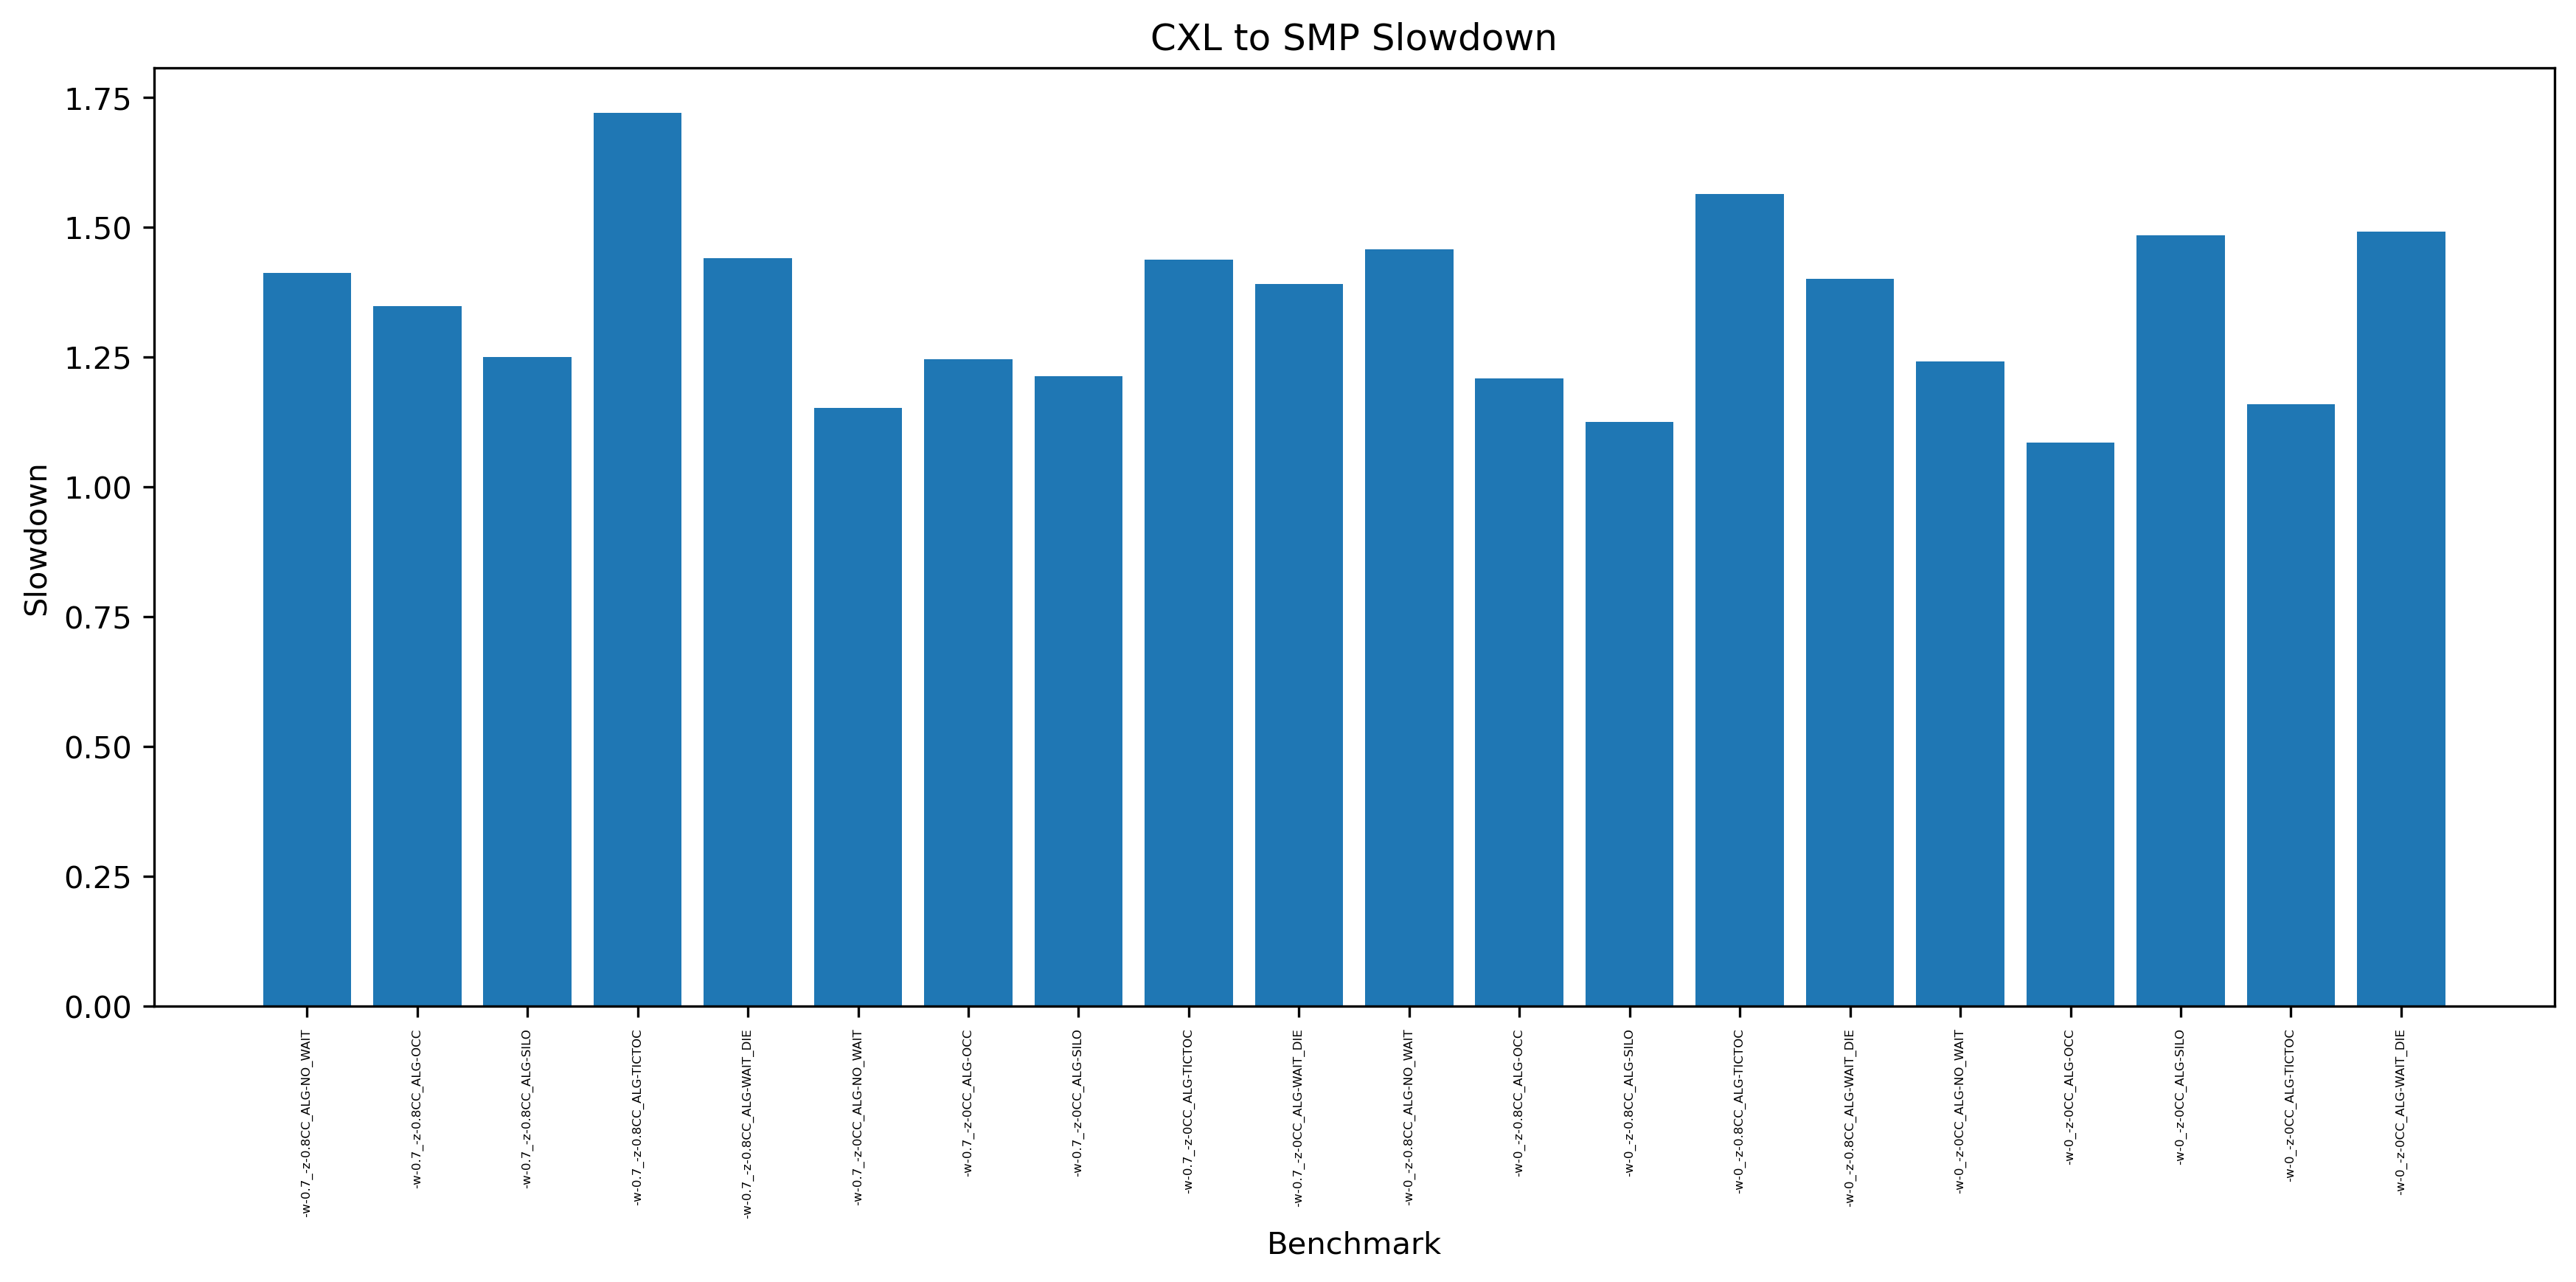

1.411861288039632
1.3482395690652436
1.2506172663307977
1.7207621592799829
1.4403248179401225
1.1532759691006038
1.2460475305172438
1.2140979144548867
1.4387495584058874
1.3908198819918054
1.4583534322820035
1.209829012102581
1.1249034180290052
1.563942124096573
1.4012343303541366
1.2421944857729081
1.086113046126488
1.4843362199201469
1.1603322360268526
1.4916402884362985
-w-0_-z-0CC_ALG-WAIT_DIE
-w-0_-z-0CC_ALG-TICTOC
-w-0_-z-0CC_ALG-SILO
-w-0_-z-0CC_ALG-OCC
-w-0_-z-0CC_ALG-NO_WAIT
-w-0_-z-0.8CC_ALG-WAIT_DIE
-w-0_-z-0.8CC_ALG-TICTOC
-w-0_-z-0.8CC_ALG-SILO
-w-0_-z-0.8CC_ALG-OCC
-w-0_-z-0.8CC_ALG-NO_WAIT
-w-0.7_-z-0CC_ALG-WAIT_DIE
-w-0.7_-z-0CC_ALG-TICTOC
-w-0.7_-z-0CC_ALG-SILO
-w-0.7_-z-0CC_ALG-OCC
-w-0.7_-z-0CC_ALG-NO_WAIT
-w-0.7_-z-0.8CC_ALG-WAIT_DIE
-w-0.7_-z-0.8CC_ALG-TICTOC
-w-0.7_-z-0.8CC_ALG-SILO
-w-0.7_-z-0.8CC_ALG-OCC
-w-0.7_-z-0.8CC_ALG-NO_WAIT


<Figure size 640x480 with 0 Axes>

In [103]:

def tput_slowdown(exec_time):
    # bm = "tput_tpcc"
    # variables = ["CC_ALG", "-n", "-Tp"]

    bm = "tput_ycsb"
    variables = ["-w", "-z", "CC_ALG"]

    # bm = "debug_ycsb"
    # variables = ["-w", "-z", "CC_ALG"]

    yvals, xval = [], []
    oracle, cxl_vanilla, cxtnl = {}, {}, {}    # local time + remote time

    cfgs, args, envs = experiment_map[bm]()
    for arg, cfg, env in itertools.product(args, cfgs, envs):
        log_path = get_log_path(cfg, arg, env, bm, exec_time)
        name = gen_simplified_name(cfg, arg, env, variables)
        try:
            _, txn_cnt, abort_cnt, run_time, time_parts = parse_log(log_path)
            
            tput = (txn_cnt - abort_cnt) / (run_time / arg['-t'])
            # tput = run_time / arg['-t']

            if env["SNIPER_CXL_LATENCY"] == 0 and env["SNIPER_MEM_LATENCY"] == 0 and env["PRIMITIVE"] == "CXTNL":
                oracle[name] = tput
            elif env["SNIPER_CXL_LATENCY"] > 0 and env["SNIPER_MEM_LATENCY"] > 0:
                if env["PRIMITIVE"] == "CXLVANILLA":
                    cxl_vanilla[name] = tput
                elif env["PRIMITIVE"] == "CXTNL":
                    cxtnl[name] = tput
        except:
            if name in oracle:
                oracle.pop(name)
            if name in cxl_vanilla:
                cxl_vanilla.pop(name)
            if name in cxtnl:
                cxtnl.pop(name)
            continue
        # print(name, sum(time_parts.values()) / run_time)

    # legend = ["Local Time", "Remote Time"]

    # res = [cxtnl[k] for k in sorted(oracle.keys(), reverse=True)]
    # res = [cxl_vanilla[k] for k in sorted(oracle.keys(), reverse=True)]

    res = [max(cxtnl[k] / cxl_vanilla[k], 1) for k in sorted(cxtnl.keys(), reverse=True)]
    # res = [max(oracle[k] / cxtnl[k], 1) for k in sorted(oracle.keys())]
    # res = [max(oracle[k] / cxtnl[k], 1) for k in sorted(oracle.keys())]
    draw_bar_plot(res, sorted(cxtnl.keys()), "CXL to SMP Slowdown", "Benchmark", "Slowdown", "./tput_slowdown.png")

    print("\r\n".join(map(str, res)))
    print("\r\n".join(map(str, sorted(cxtnl.keys(), reverse=True))))

    # return yvals, xval

# tput_slowdown("20240530-170723")
# tput_slowdown("20240528-211236")    # TPCC
# tput_slowdown("20240528-130806")    # YCSB
tput_slowdown("20240531-100934")

In [ ]:

def tput_breakdown(exec_time):
    bm = "tput_tpcc"
    variables = ["-n", "-Tp", "CC_ALG"]

    # bm = "tput_ycsb"
    # variables = ["-w", "-z", "CC_ALG"]

    cfgs, args, envs = experiment_map[bm]()
    yvals, xval = [], []
    legend = []

    for cfg, arg, env in itertools.product(cfgs, args, envs):
        if not (env["SNIPER_CXL_LATENCY"] > 0 and env["SNIPER_MEM_LATENCY"] > 0 and env["PRIMITIVE"] == "CXLVANILLA"):
            continue
        log_path = get_log_path(cfg, arg, env, bm, exec_time)
        _, txn_cnt, abort_cnt, run_time, time_parts = parse_log(log_path)

        name = gen_simplified_name(cfg, arg, env, variables)

        compute = time_parts['time_log'] + time_parts['time_query'] + time_parts['useful_work'] + time_parts['time_index']
        txn_manager_tl = time_parts['time_man'] + time_parts['time_cleanup'] + time_parts['time_wait']
        memory_layer = time_parts['time_shared_record'] + time_parts['time_shared_metadata']

        # yvals.append([time_parts['time_shared_record'], time_parts['time_shared_metadata']])
        # legend = ["record", "metadata"]
        yvals.append([memory_layer, compute + txn_manager_tl])
        legend = ["shared memory", "local memory"]
        # yvals.append([version_management, conflict_detection])
        # legend = ['Version Management', 'Conflict Detection']

        xval.append(name)

    
    for i, row in enumerate(yvals):
        row_sum = sum(row)
        if row_sum == 0:
            continue  # Avoid division by zero
        yvals[i] = [element / row_sum for element in row]
        # print(yvals[i][2])

        # legend = list(time_parts.keys()) # Detailed breakdown
    draw_stacked_bar_plot(yvals, xval, legend, "CXL TPCC Breakdown", "Benchmark", " ", "./cxl_tpcc_breakdown.png", True)


    return yvals, xval, legend

tput_breakdown("20240528-211236")    # TPCC
# tput_breakdown("20240528-130806")    # YCSB


{'directory-cxl-cache-overhead': 247219819.0, 'l3-miss-rate': 0.983505186314, 'directory-evict-cnt': 181519.0, 'directory-entries-allocated': 898243.0, 'ideal-directory-evict-cnt': 334298.0, 'cxl-mem-read-cnt': 21487042.0, 'directory-cxl-bi-overhead': 230529130.0, 'cxl-mem-write-cnt': 16022693.0, 'bus-packets': 2662021.0, 'cxl-mem-overhead': 138456192.0, 'load-from-remote-cache': 123693.0, 'load-from-dram': 577956.0, 'l3-access': 1236813.0, 'l3-cxl-cache-overhead': 0.0, 'load-hit-l3': 19762.0, 'load-hit-l1': 235156531.0}
{'directory-cxl-cache-overhead': 159653571.0, 'l3-miss-rate': 0.983099068356, 'directory-evict-cnt': 32227.0, 'directory-entries-allocated': 279969.0, 'ideal-directory-evict-cnt': 381896.0, 'cxl-mem-read-cnt': 20265291.0, 'directory-cxl-bi-overhead': 40928290.0, 'cxl-mem-write-cnt': 10471077.0, 'bus-packets': 2848265.0, 'cxl-mem-overhead': 151562682.0, 'load-from-remote-cache': 126571.0, 'load-from-dram': 616568.0, 'l3-access': 1323359.0, 'l3-cxl-cache-overhead': 0.0, 

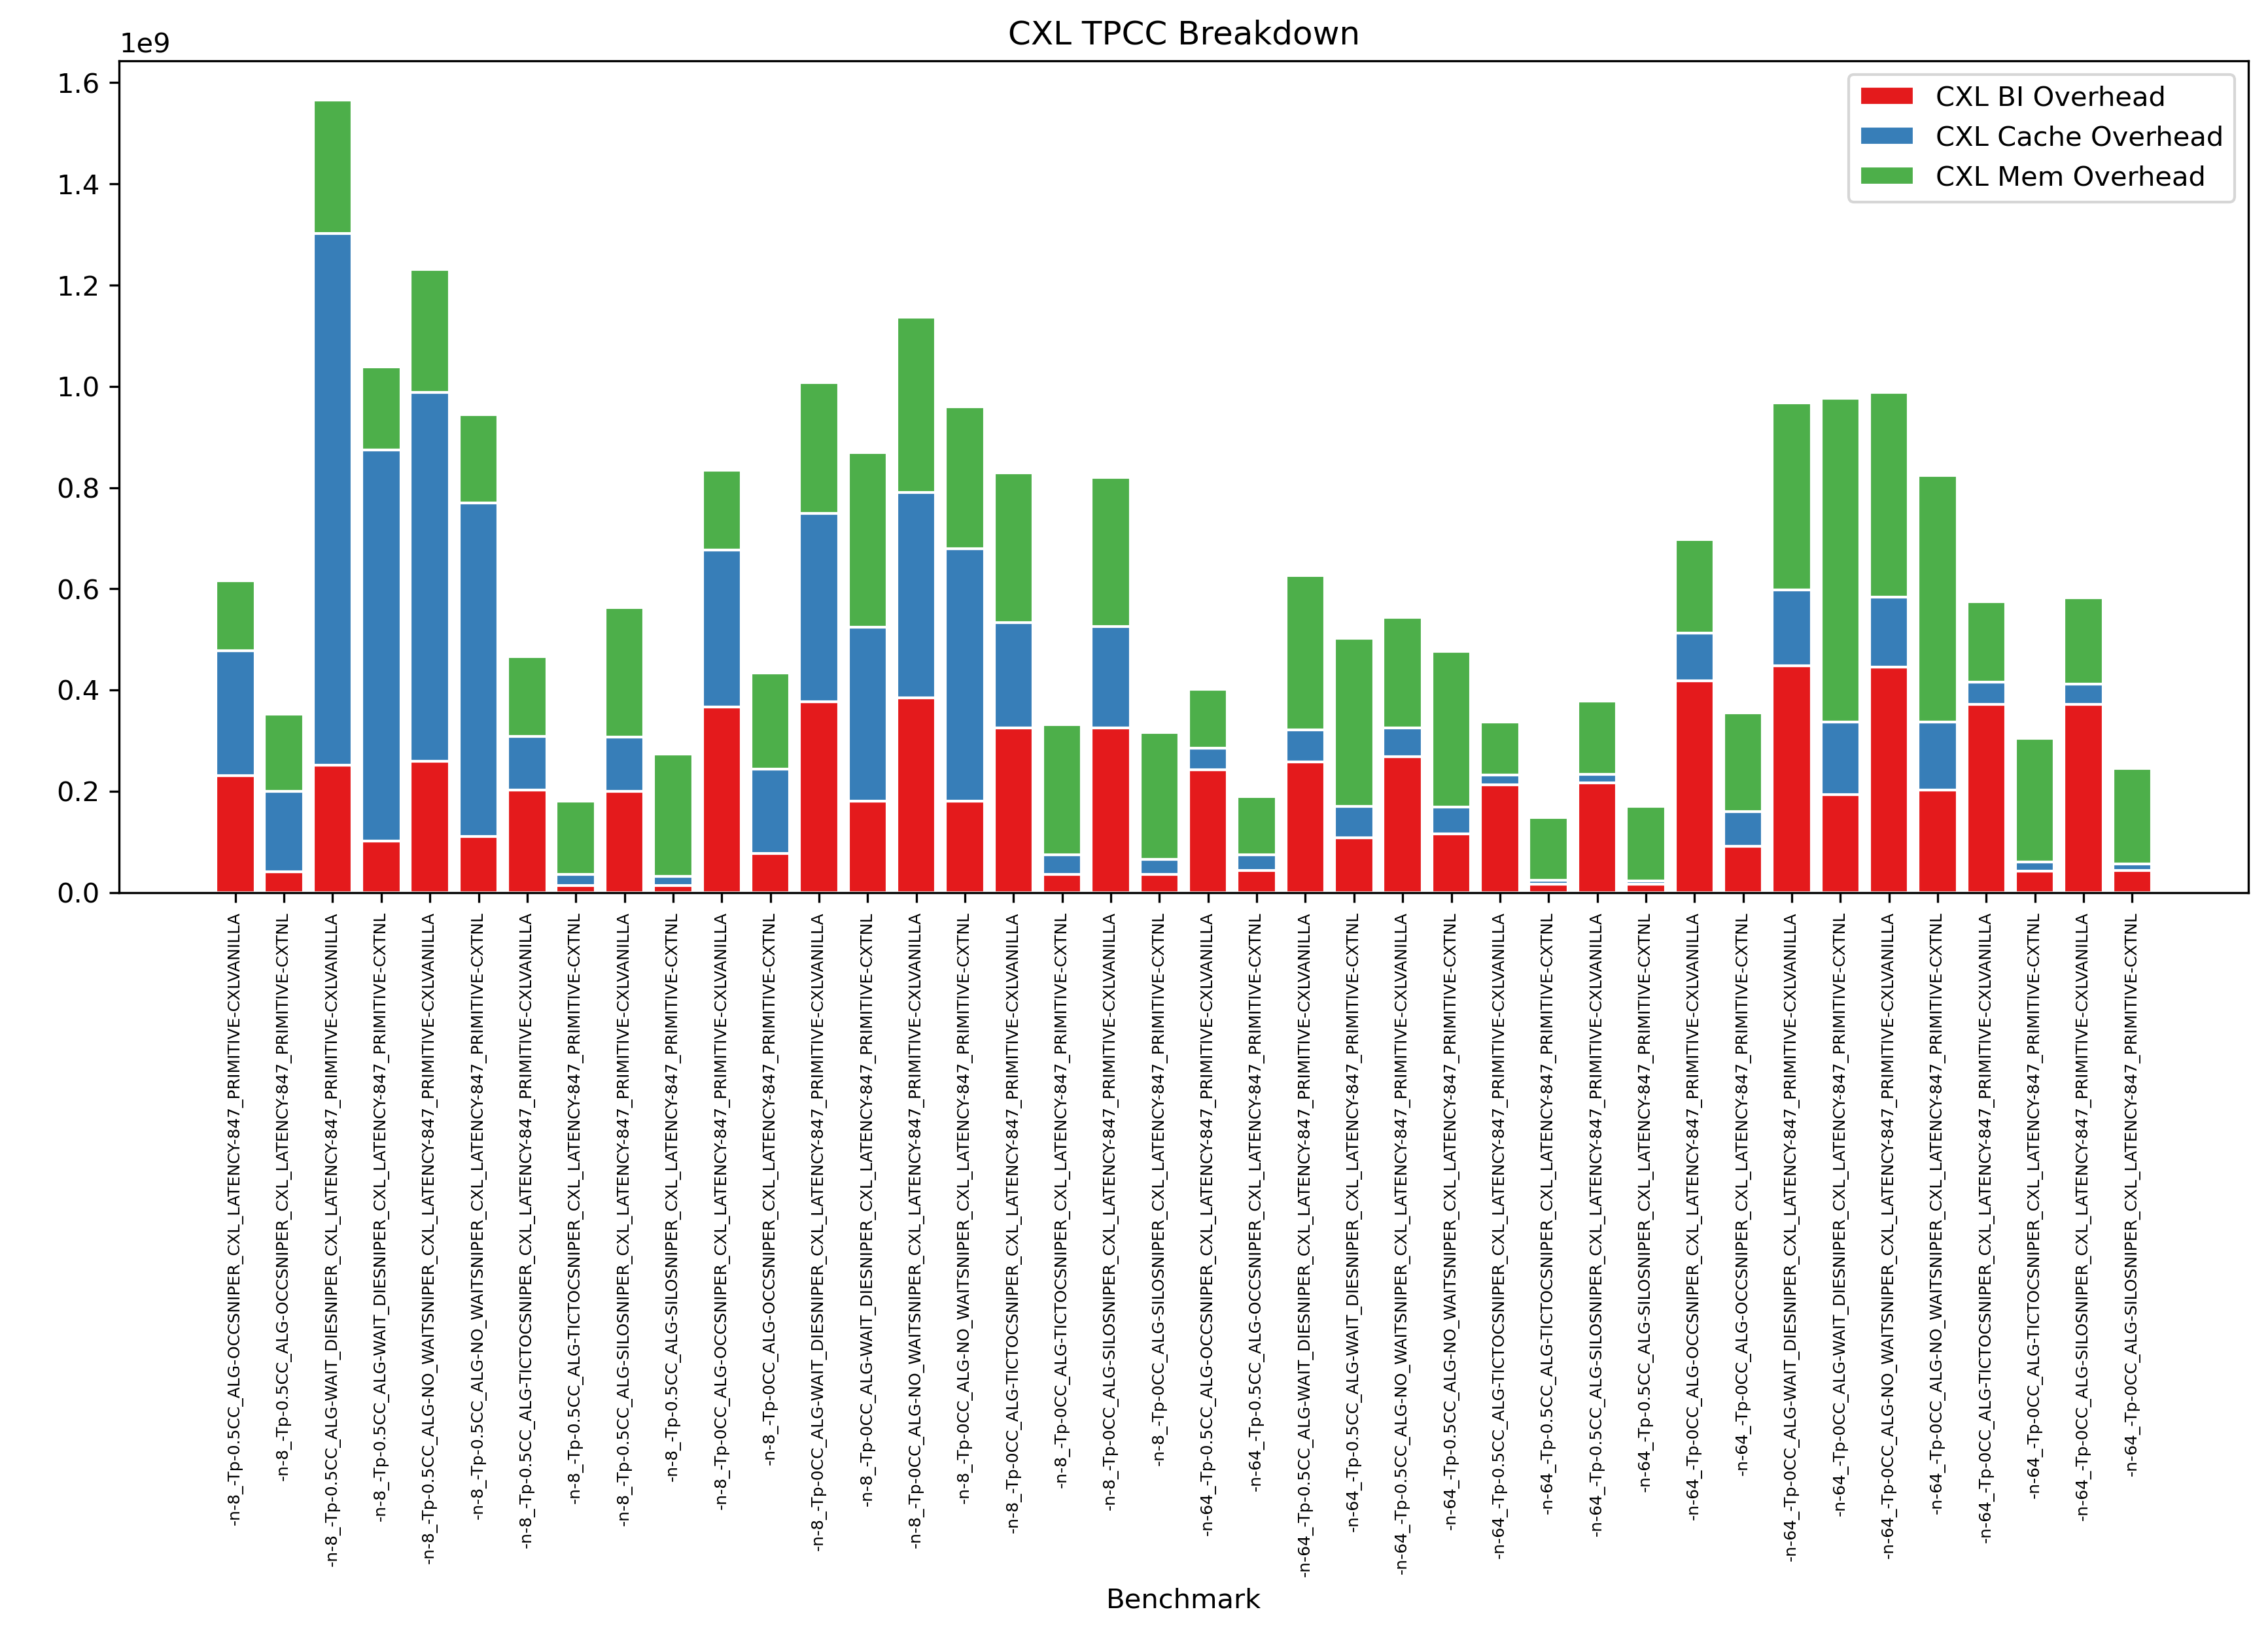

([[230529130.0, 247219819.0, 138456192.0],
  [40928290.0, 159653571.0, 151562682.0],
  [251664470.0, 1050122458.0, 263327688.0],
  [101429820.0, 773318623.0, 163581352.0],
  [259029200.0, 729227191.0, 242524512.0],
  [110849410.0, 659065099.0, 173861610.0],
  [202413870.0, 106636453.0, 156953376.0],
  [13997940.0, 21638309.0, 145138494.0],
  [200493630.0, 106550906.0, 256275192.0],
  [13914120.0, 17792929.0, 241873628.0],
  [366157510.0, 310740584.0, 156864456.0],
  [76629260.0, 167108865.0, 190274532.0],
  [376426730.0, 372495354.0, 258555648.0],
  [179997100.0, 344241975.0, 344428826.0],
  [384844290.0, 405106548.0, 346265880.0],
  [181148990.0, 498656004.0, 279997996.0],
  [324703440.0, 208049457.0, 296174736.0],
  [36003230.0, 38972164.0, 256695684.0],
  [324980300.0, 200469654.0, 295319280.0],
  [36229290.0, 29031772.0, 250722174.0],
  [242868450.0, 42560903.0, 115817160.0],
  [43558460.0, 31715915.0, 114259594.0],
  [257966210.0, 63423360.0, 304849680.0],
  [107944920.0, 62638191

<Figure size 640x480 with 0 Axes>

In [93]:
def tput_memstatus(exec_time=""):
    bm = "tput_tpcc"
    variables = ["-n", "-Tp", "CC_ALG", "SNIPER_CXL_LATENCY", "PRIMITIVE"]

    # bm = "tput_ycsb"
    # variables = ["-w", "-z", "CC_ALG", "SNIPER_CXL_LATENCY"]
    # variables = ["-w", "-z", "CC_ALG", "SNIPER_CXL_LATENCY", "PRIMITIVE"]

    # bm = "debug_ycsb"
    # variables = ["-w", "-z", "CC_ALG", "PRIMITIVE"]

    cfgs, args, envs = experiment_map[bm]()

    yvals, xval = [], []

    for arg, cfg, env in itertools.product(args, cfgs, envs):
        if not (env["SNIPER_CXL_LATENCY"] > 0 and env["SNIPER_MEM_LATENCY"] > 0) :
        # if not (env["PRIMITIVE"] == "CXLVANILLA") :
            continue
        name = gen_simplified_name(cfg, arg, env, variables)

        memstatus_tool = os.path.join(env["SNIPER_ROOT"], "tools/gen_memstatus.py")
        home = get_sniper_result_dir(cfg, arg, env, bm, exec_time)
        memstatus_cmd = "{} {} {}".format("python2", memstatus_tool, "--partial roi-begin:roi-end")
        res = subprocess.Popen(memstatus_cmd, shell=True, cwd=home, stdout=subprocess.PIPE, stderr=subprocess.PIPE).communicate()[0].decode()
        data = parse_memstatus_output(res)
        print(data)

        log_path = get_log_path(cfg, arg, env, bm, exec_time)
        _, txn_cnt, abort_cnt, run_time, time_parts = parse_log(log_path)

        # yval = [run_time / arg['-t']]
        # yval = [data["directory-cxl-cache-overhead"] / 875 / (data["cxl-mem-read-cnt"] + data["cxl-mem-write-cnt"])]
        yval = [data["directory-cxl-bi-overhead"] , data["directory-cxl-cache-overhead"] , data["cxl-mem-overhead"]]
        # yval = [data["directory-evict-cnt"] / (data["ideal-directory-evict-cnt"])]a
        # yval = [data["directory-evict-cnt"] * 875 * 1.5 / (data["directory-cxl-cache-overhead"])]
        # yval = [data["directory-entries-allocated"]]
        # yval = [(data["cxl-mem-read-cnt"] + data["cxl-mem-write-cnt"]) / (1000 / 64 * 50 * 64)]
        yvals.append(yval)
        xval.append(name)
    
    legend = [""]
    legend = ["CXL BI Overhead", "CXL Cache Overhead", "CXL Mem Overhead"]
    draw_stacked_bar_plot(yvals, xval, legend, "CXL TPCC Breakdown", "Benchmark", " ", "./cxl_tpcc_breakdown.png", False)

    return yvals, xval, legend

tput_memstatus("20240528-211236")    # TPCC
# tput_memstatus("20240528-130806")    # YCSB
# tput_memstatus("20240530-153713")
# tput_memstatus("20240530-170723")


In [ ]:
# tput_slowdown("20240526-181220")    # TPCC
# tput_slowdown("20240526-104814")    # YCSB
# tput_breakdown("20240526-104814")
# tput_memstatus("20240526-104814")

In [ ]:
def cpi(exec_time):
    # bm = "tput_tpcc"
    # variables = ["-n", "-Tp", "CC_ALG"]

    bm = "tput_ycsb"
    variables = ["-w", "-z", "CC_ALG", "SNIPER_CXL_LATENCY"]
    cfgs, args, envs = experiment_map[bm]()

    yvals, xval = [], []

    # legend = set()  # Create an empty set to store all keys
    for arg, cfg, env in itertools.product(args, cfgs, envs):
        if not (env["SNIPER_CXL_LATENCY"] > 0 and env["SNIPER_MEM_LATENCY"] > 0 and env["PRIMITIVE"] == "CXLVANILLA") :
        # if not (env["PRIMITIVE"] == "CXLVANILLA") :
            continue

        name = gen_simplified_name(cfg, arg, env, variables)

        cpi_plot_tool = os.path.join(env["SNIPER_ROOT"], "tools/cpistack.py")
        home = get_sniper_result_dir(cfg, arg, env, bm, exec_time)
        cpi_cmd = "{} {} {}".format("python2", cpi_plot_tool, "--abstime --partial roi-begin:roi-end")
        res = subprocess.Popen(cpi_cmd, shell=True, cwd=home, stdout=subprocess.PIPE, stderr=subprocess.PIPE).communicate()[0].decode()
        print(res)
        data = parse_cpi_output(res)
        # Get the summation of all cores
        data = {key: sum(value.values()) for key, value in data.items()}
        yvals.append(data)

        # legend.update(data.keys())
        xval.append(name)

    # legend = list(legend)  # Convert the set to a list to preserve order

    # Detailed Description
    legend = ['sync-futex', 'sync-unscheduled', 'mem-remote', 'mem-l1d', 'mem-l3', 'mem-dram', 'base', 'other']
    # printed_legend = ['sync', 'mem-cxl', 'cache-processor', 'compute']
    printed_legend = ['sync', 'cxl-coherence', 'cxl-mem', 'processor-cache', 'compute']
    for i in range(len(yvals)):
        yvals[i] = [yvals[i].get(key, 0) for key in legend]     # filter
        yvals[i] = [
            yvals[i][0] + yvals[i][1],
            yvals[i][2],  # sync
            yvals[i][5],
            # yvals[i][2] + yvals[i][5], # mem-cxl
            yvals[i][3] + yvals[i][4],  # mem-private
            yvals[i][6] + yvals[i][7]   # compute
        ]
        # yvals[i] = [element / sum(yvals[i]) for element in yvals[i]]

    # legend = ['sync-futex', 'sync-unscheduled', 'mem-remote', 'mem-l1d', 'mem-l3', 'mem-dram']
    # printed_legend = ['sync', 'mem-cxl-coherence',  'mem-cxl-memory', 'processor-cache']
    # for i in range(len(yvals)):
    #     yvals[i] = [yvals[i].get(key, 0) for key in legend]     # filter
    #     yvals[i] = [
    #         yvals[i][0] + yvals[i][1],  # sync
    #         yvals[i][2],  # mem-cxl-coherence
    #         yvals[i][3] + yvals[i][4],  # mem-private
    #         yvals[i][5],  # mem-cxl-memory
    #         yvals[i][6] + yvals[i][7]  # compute
    #     ]
    #     yvals[i] = [element / sum(yvals[i]) for element in yvals[i]]

    draw_stacked_bar_plot(yvals, xval, printed_legend, "CXL TPCC CPI", "Benchmark", "CPI", "./cxl_tpcc_cpi.png", False)
    return yvals, xval, printed_legend

# cpi("20240528-211236")    # TPCC
cpi("20240528-130806")    # YCSB


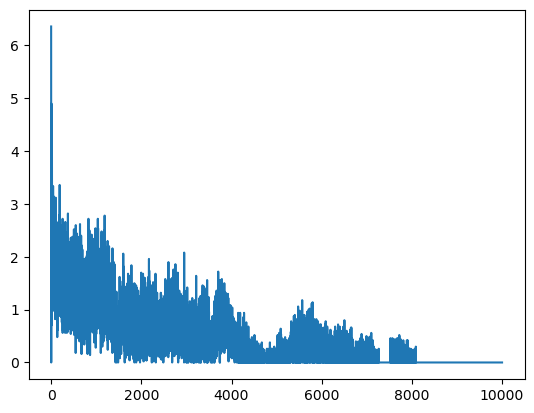

In [14]:
import matplotlib.pyplot as plt

# Read the log file
# Parse the log file
data = []
with open('/home/wangzhao/snipersim/fk.log', 'r') as f:
    lines = f.readlines()

interval = 1e4 / 1e9
for i, line in enumerate(lines):
    if "EP-Bus-Record:" in line:
        numbers = lines[i + 1].split(',')
        numbers = [num for num in numbers if num not in ('', '\n')]
        data.append([int(num) / interval / 1e9 for num in numbers])

res = [0 for _ in data[0]]
for i in range(len(data[0])):
    for j in range(len(data)):
        res[i] += data[j][i]

# Draw a line plot
plt.plot(res)
plt.show()